# Classification trees with R

Since this was the first time I am picking up R, I wanted to try a data analysis project with it. As such, this notebook contain my approach with the various classification trees, including the basic decision tree to the more advanced methods such as random forest. I have also explained why certain parameters are used.

## Load cleaned data

In [28]:
train <- read.csv('cleanTrain.csv')

## Split data into train and test sets

Due to the class imbalance of status_group, we chose a stratified sampling method. This maintains the same proportion of classes in the training and validation set as in the original dataset.

In [2]:
library(caret)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.2"

In [29]:
train_ind <- createDataPartition(train$status_group, p = .7, list = FALSE)
train_sub <- train[train_ind,]
val_sub  <- train[-train_ind,]

## Classification trees

In [59]:
library(tree)
library(rpart) 
library(caret) # for confusionMatrix

In [60]:
tree1 <- tree(status_group~.,
              data = train_sub)
summary(tree1)


Classification tree:
tree(formula = status_group ~ ., data = train_sub)
Variables actually used in tree construction:
[1] "quantity"        "waterpoint_type" "payment_type"    "source"         
Number of terminal nodes:  5 
Residual mean deviance:  1.458 = 60610 / 41580 
Misclassification error rate: 0.3048 = 12674 / 41581 

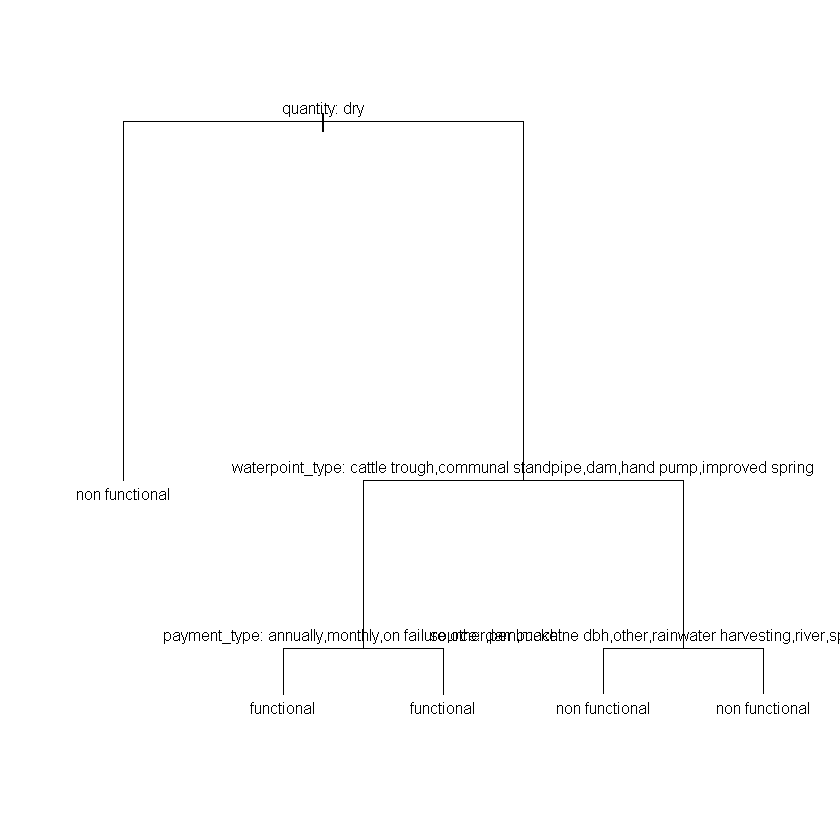

In [61]:
plot(tree1)
text(tree1,pretty=0,cex=.8)

quantity_group has the highest importance, followed by waterpoint_type, amount_tsh and extraction_type.

In [62]:
tree1.pred <- predict(object = tree1,
                      newdata = val_sub, type = 'class')
tree1.table <- table(tree1.pred, val_sub$status_group)
tree1.table

                         
tree1.pred                functional functional needs repair non functional
  functional                    8721                     979           3147
  functional needs repair          0                       0              0
  non functional                 956                     316           3700

type='class' means that R will return the actual class prediction.

### Create functions for evaluation metrics

We will use **accuracy** as the evaluation metrics. I was thinking of using the recall score and micro-average recall score. However, I came to realise that the micro-average recall score is the same as the accuracy score! Here is my thought process: 

In our challenge, the impact of incorrectly classifying a non-functional waterpoint as a functional waterpoint is more severe than incorrectly classifying a functional waterpoint as a non-functional waterpoint. Thus, we focus on the recall scores (the proportion of actual positives which are wrongly classified). 

- Recall = TP / (TP+FN)

For multiclass classification, it can come across as confusing as to which value is a true positive or a false negative. It is easier to think of it as the proportion of correctly predicted x out of the actual number of x. For example, 

**Recall score of functional waterpoints = correct prediction of functional waterpoints / actual number of functional 
waterpoints**
= 8804 / (8804+0+873)

Note that there is a recall score for each class.

It can be tedious trying to compare the recall score for each class every time a tree model is ran. Thus, we use a single value, the micro-average recall score instead. The micro-average recall score calculates the individual TP and FN of each class and imbue into the formula. In contrast, the macro-average recall score is simply the average of individual recall scores.

- Micro-average recall = (TP1+TP2+TP3) / (TP1+TP2+TP3+FN1+FN2+FN3)
- Macro-average recall = (R1+R2+R3) / 3

We use the micro-average recall score due to the presence of imbalance classes.

You may be quick to realise that the **micro-average recall = accuracy** for a multi-class classification problem since it is essentially the number of correct predictions out of the total dataset.

In [63]:
# Create function that calculates accuracy score
accuracy <- function(table){
    acc = (table[1,1]+table[2,2]+
                     table[3,3])/sum(table)
    return(acc)
}

In [64]:
# Create function that calculates recall score
recall1 <- function(table){
    rec = (table[1,1])/
        (table[1,1]+table[1,2]+table[1,3])
    return(rec)
}
recall2 <- function(table){
    rec = (table[2,2])/
        (table[2,1]+table[2,2]+table[2,3])
    return(rec)
}
recall3 <- function(table){
    rec = (table[3,3])/
        (table[3,1]+table[3,2]+table[3,3])
    return(rec)
}

In [65]:
tree1.acc <- accuracy(tree1.table)
tree1.acc

[1] 0.6970649

In [66]:
tree1.rec1 <- recall1(tree1.table)
tree1.rec2 <- recall2(tree1.table)
tree1.rec3 <- recall3(tree1.table)
cat(tree1.rec1,tree1.rec2,tree1.rec3)

0.6788355 NaN 0.7441673

### Pruning the tree

In [67]:
tree1.cv <- cv.tree(tree1,FUN=prune.misclass)

FUN=prune.misclass means that we are using the classification error rate to guide the cross-validation and pruning process.

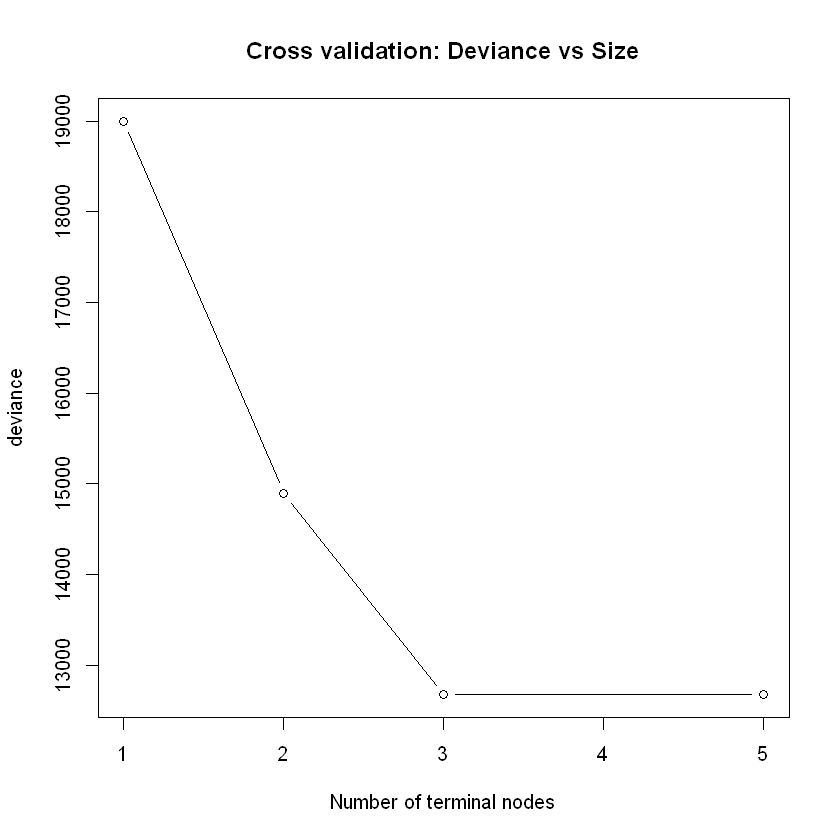

In [68]:
plot(tree1.cv$size, tree1.cv$dev, type='b',
     main='Cross validation: Deviance vs Size',
     xlab='Number of terminal nodes', ylab='deviance')

In [69]:
tree1.nn <- tree1.cv$size[which.min(tree1.cv$dev)]
tree1.nn

[1] 5

The cross-validation error rate is lowest with 5 terminal nodes on each tree. That is actually the same as the previous decision tree. However, we will still prune the tree with 5 nodes for completeness.

Note that size represents number of terminal nodes of each tree while dev refers to the cross-validation error rate.

In [70]:
tree1.prune <- prune.misclass(tree1, best=tree1.nn)

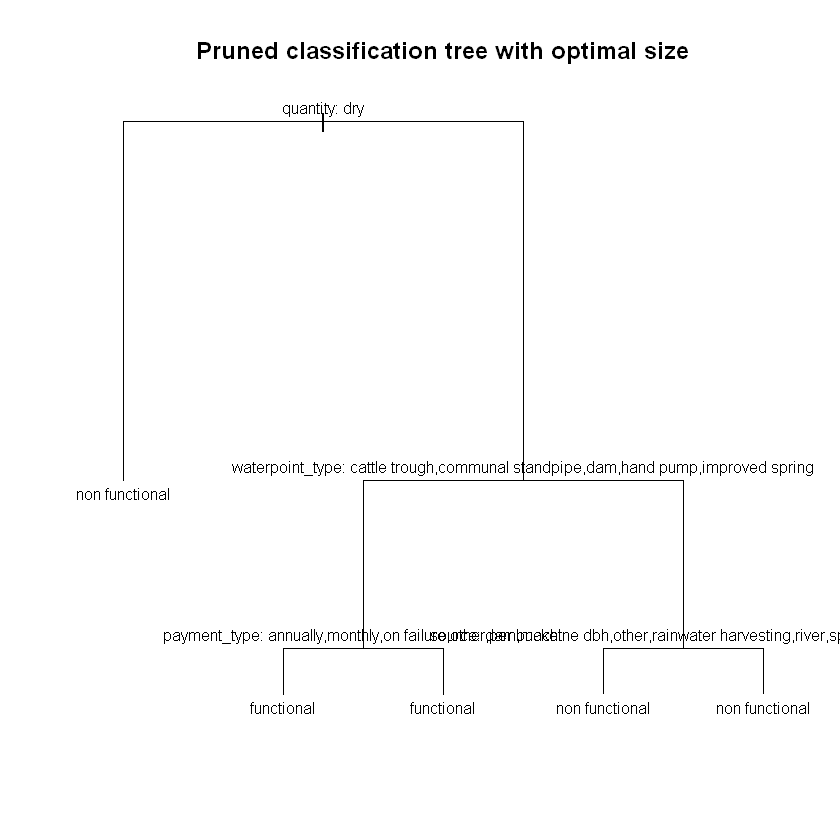

In [71]:
plot(tree1.prune)
title('Pruned classification tree with optimal size')
text(tree1.prune,pretty=0,cex=.8)

In [72]:
tree1.pred2 <- predict(object = tree1.prune,
                       newdata = val_sub, type = 'class')
tree1.table2 <- table(tree1.pred2, val_sub$status_group)
tree1.table2

                         
tree1.pred2               functional functional needs repair non functional
  functional                    8721                     979           3147
  functional needs repair          0                       0              0
  non functional                 956                     316           3700

In [73]:
tree1.acc2 <- accuracy(tree1.table2)
tree1.acc2

[1] 0.6970649

In [74]:
tree1.rec21 <- recall1(tree1.table2)
tree1.rec22 <- recall2(tree1.table2)
tree1.rec23 <- recall3(tree1.table2)
cat(tree1.rec21,tree1.rec22,tree1.rec23)

0.6788355 NaN 0.7441673

## Bagging

In [5]:
library(randomForest)

Warning message:
"package 'randomForest' was built under R version 3.6.3"randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin



In [76]:
ncol(train_sub)

[1] 15

In [77]:
sum(is.na(train_sub))

[1] 0

In [78]:
bag1 <- randomForest(status_group~., data = train_sub,
                     mtry = 14, importance = TRUE)
bag1


Call:
 randomForest(formula = status_group ~ ., data = train_sub, mtry = 14,      importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 14

        OOB estimate of  error rate: 22.26%
Confusion matrix:
                        functional functional needs repair non functional
functional                   19652                     626           2304
functional needs repair       1721                     842            459
non functional                3851                     296          11830
                        class.error
functional                0.1297494
functional needs repair   0.7213766
non functional            0.2595606

mtry = 15 is used to reflect that all 15 variables are considered at each split.

In [79]:
bag1.pred <- predict(object = bag1,
                     newdata = val_sub, type = 'class')

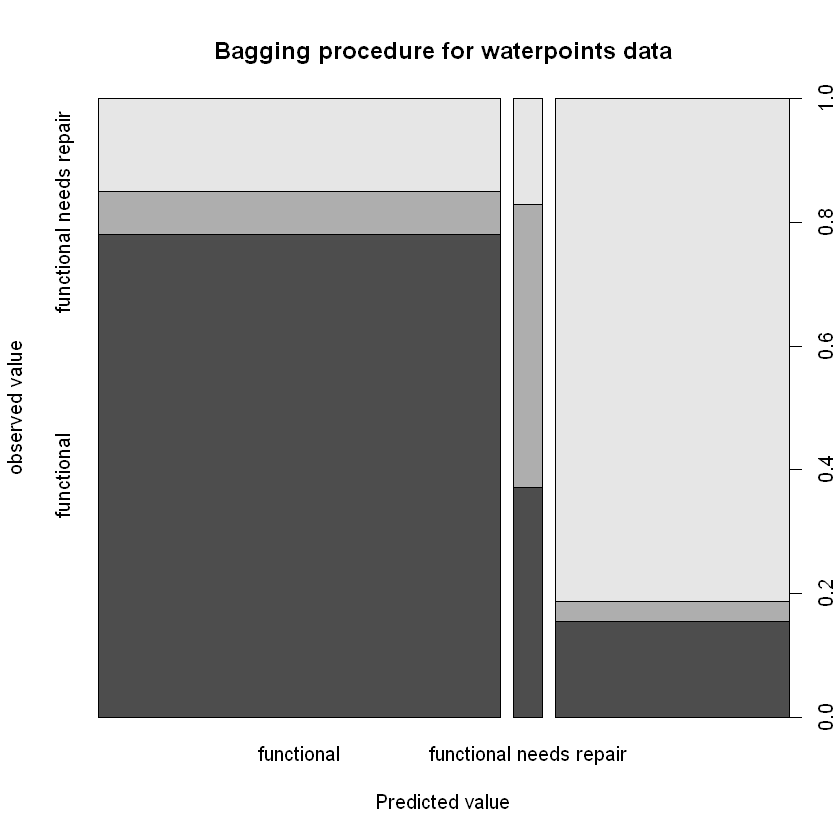

In [80]:
plot(bag1.pred,val_sub$status_group, 
     main='Bagging procedure for waterpoints data',
     xlab='Predicted value', ylab='observed value')

In [81]:
importance(bag1)

,functional,functional needs repair,non functional,MeanDecreaseAccuracy,MeanDecreaseGini
amount_tsh,49.23339,16.13335,38.82491,50.42419,459.7344
gps_height,117.40899,68.67410,102.35164,161.80937,3461.3897
installer,159.62813,101.13842,151.06737,253.08666,1120.7334
basin,171.24950,167.21931,166.36659,269.25058,1160.2828
population,128.98453,31.48609,69.23384,161.13376,1912.3060
scheme_management,99.51297,55.71149,78.43427,135.56032,648.6037
permit,96.69771,55.66971,50.62664,122.62045,371.3971
construction_year,162.53493,79.17351,120.75240,238.30404,1786.5247
management,79.34189,31.06962,80.87765,109.50494,633.3944
payment_type,160.67194,113.05312,148.43324,229.33862,956.1143


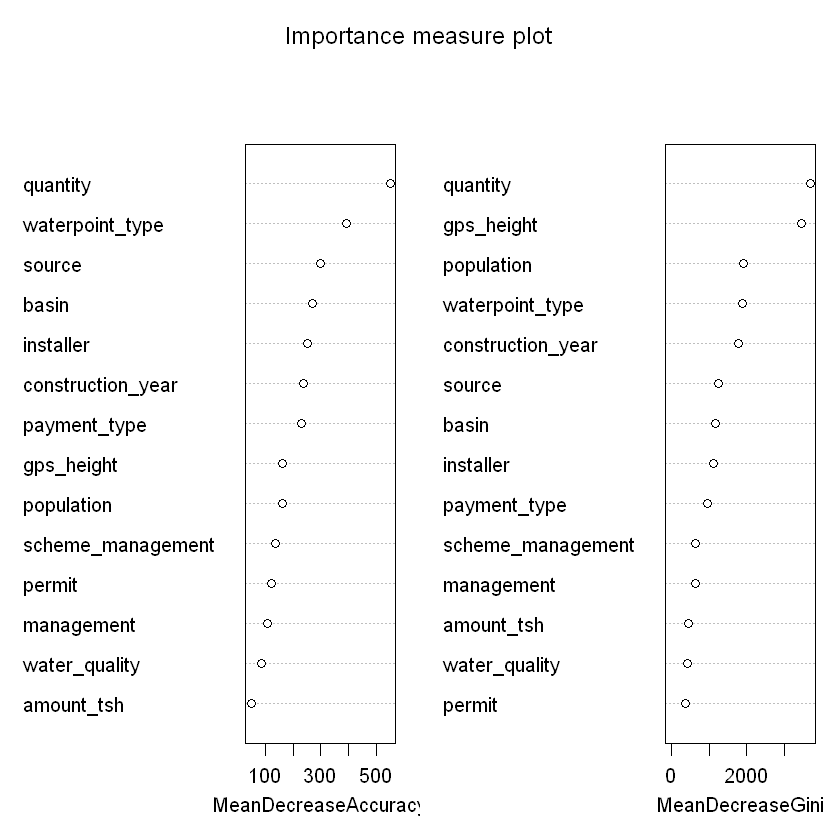

In [82]:
varImpPlot(bag1,main='Importance measure plot')

The most important variable is quantity.

In [83]:
bag1.table <- table(bag1.pred, val_sub$status_group)
bag1.table

                         
bag1.pred                 functional functional needs repair non functional
  functional                    8419                     742           1622
  functional needs repair        286                     351            132
  non functional                 972                     202           5093

In [84]:
bag1.acc <- accuracy(bag1.table)
bag1.acc

[1] 0.7779898

In [85]:
bag1.rec1 <- recall1(bag1.table)
bag1.rec2 <- recall2(bag1.table)
bag1.rec3 <- recall3(bag1.table)
cat(bag1.rec1,bag1.rec2,bag1.rec3)

0.780766 0.4564369 0.8126695

## Random forest

In [30]:
rf1 <- randomForest(status_group~., data = train_sub,
                    importance = TRUE)

mtry = 4 is used because the square root of p variables is used for building of random forest for classification. 

Note that p/3 predictors are used when building random forest for regression.

In [31]:
rf1.pred <- predict(object = rf1,
                    newdata = val_sub, type = 'class')

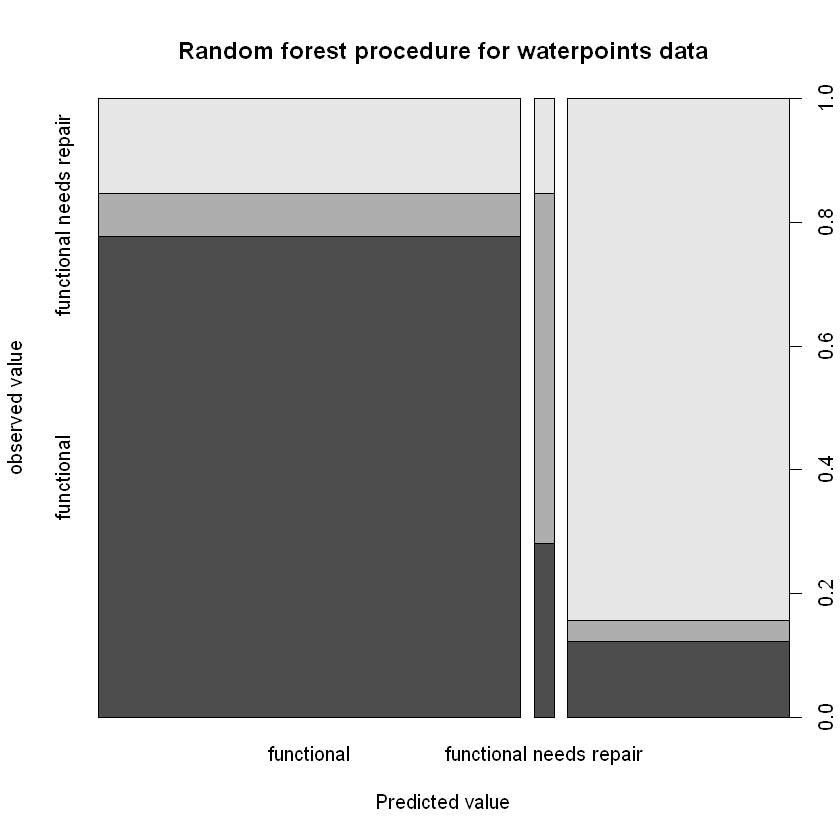

In [88]:
plot(rf1.pred,val_sub$status_group, 
     main='Random forest procedure for waterpoints data',
     xlab='Predicted value', ylab='observed value')

In [89]:
importance(rf1)

,functional,functional needs repair,non functional,MeanDecreaseAccuracy,MeanDecreaseGini
amount_tsh,45.36352,31.24648,32.13952,44.66662,659.4312
gps_height,76.12397,52.68341,69.87853,103.18111,1840.2090
installer,113.27537,63.71484,98.46665,145.75593,1007.0301
basin,110.36266,90.53652,100.47954,147.83129,1116.6429
population,64.22410,31.39649,46.60516,80.24587,1320.5170
scheme_management,81.15919,40.47454,63.21350,100.22478,642.5899
permit,68.91376,49.18712,59.72954,93.78128,365.5670
construction_year,86.33586,59.28081,76.23371,105.95469,1492.7035
management,64.21877,29.26888,53.13155,73.83199,589.9344
payment_type,72.40083,61.38195,81.77379,90.14619,991.0179


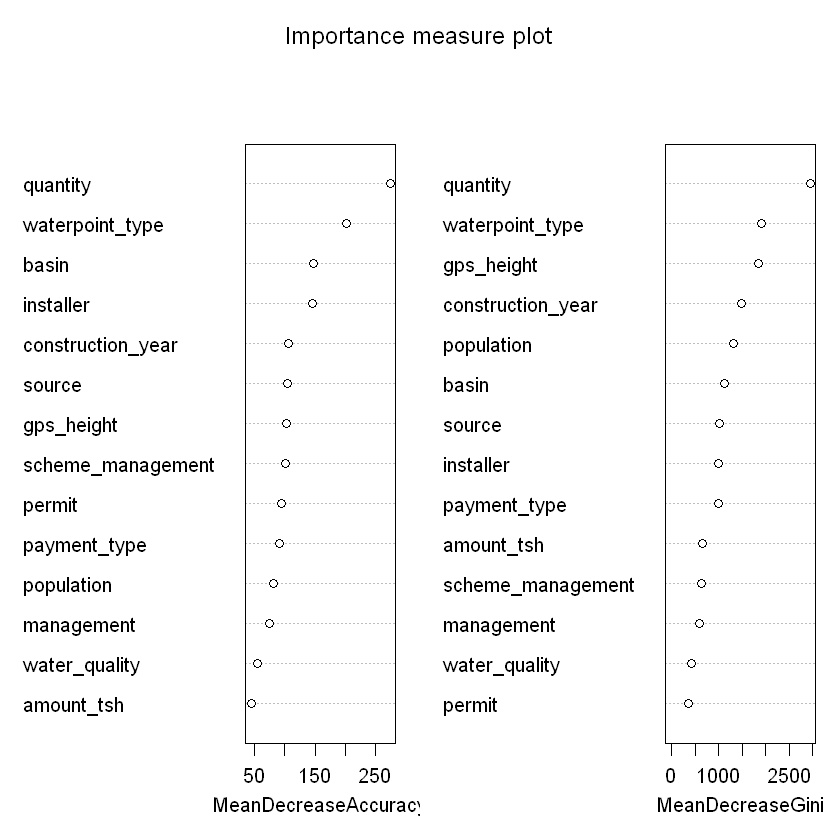

In [90]:
varImpPlot(rf1,main='Importance measure plot')

In [91]:
rf1.table <- table(rf1.pred, val_sub$status_group)
rf1.table

                         
rf1.pred                  functional functional needs repair non functional
  functional                    8795                     792           1740
  functional needs repair        150                     303             82
  non functional                 732                     200           5025

In [92]:
rf1.acc <- accuracy(rf1.table)
rf1.acc

[1] 0.792581

Accuracy only increased marginally.

In [93]:
rf1.rec1 <- recall1(rf1.table)
rf1.rec2 <- recall2(rf1.table)
rf1.rec3 <- recall3(rf1.table)
cat(rf1.rec1,rf1.rec2,rf1.rec3)

0.7764633 0.5663551 0.8435454

However, notably, the recall score for functional but needs repair has improved >10%.